## ADVERSARIAL ON INCEPTION.V3

A demo to show how to perform adversarial attacks in *Inception V3* model.

Dataset used: 
1.   *CIFAR10*
2.   *MNIST*
3.   *Imagenet* (*TODO*)

**1. Setting colab enviroment**

Please change the directory in a way that the *data* is presented OR will be downloaded in the the sibling folder of *src*. <br>

If your project folder is 
```my_project_folder```
set the directory to 
```.../my_project_folder/src```
so that the data will be downloaded or retireved in
```.../my_project_folder/data```



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd /content/gdrive/My Drive/Colab Notebooks/Adversarial/src

/content/gdrive/My Drive/Colab Notebooks/Adversarial/src


**2. Import modules**

In [0]:
### BASE
import math
import os
import time
from tqdm import tqdm
### CLASSIC
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import accuracy_score, confusion_matrix
### TORCH
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.autograd import Variable
from torch import nn, optim
### CUSTOM
import cifar10
import mnist
import inception3

In [4]:
### Set GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device is {}'.format(device))

Device is cuda


**3. Download InceptionV3**

Inception model is a very deep model with deep 2D Convolutional Layer and a final Classification Linear Layer. Its architecture make him suitable for image classifcation task.

Inception requeires an input of shape *(N, 3, 229, 229)*  where: <br>


*   N is the batch dimension
*   3 is the number of channels
*   229, 299 are the images dimension

In [5]:
model = inception3.InceptionV3(pre_trained=True, freeze=False)

Found device: cuda


**4. CIFAR10**

We try to use *InceptionV3* model to perfrom classification on the *CIFAR10* dataset.

The images of *CIFAR10* are divided in 10 categories: <br>
*plane*, *car*, *bird*, *cat*, *deer*, *dog*, *frog*, *horse*, *ship* and *truck*.

**4.1 Dataset**

We call the CIFAR10 object that return the *trainset* and the *testset* of the desired batch size.

The *cifar10* get the data in the following way:
```
self.train_dataset = datasets.CIFAR10(root='../data/cifar10', train=True, download=True, transform=self.transform)
self.test_dataset = datasets.CIFAR10(root='../data/cifar10', train=False, download=True, transform=self.transform)
```

The *cifar10* object use the following steps in the *transform.compose*:
```
transforms.Compose([transforms.Resize(self.dim, PIL.Image.LANCZOS),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
```

Files already downloaded and verified
Files already downloaded and verified

Batch is a <class 'list'>
The 1st element is a <class 'torch.Tensor'> with shape torch.Size([64, 3, 299, 299])
The 2nd element is a <class 'torch.Tensor'> with shape torch.Size([64])


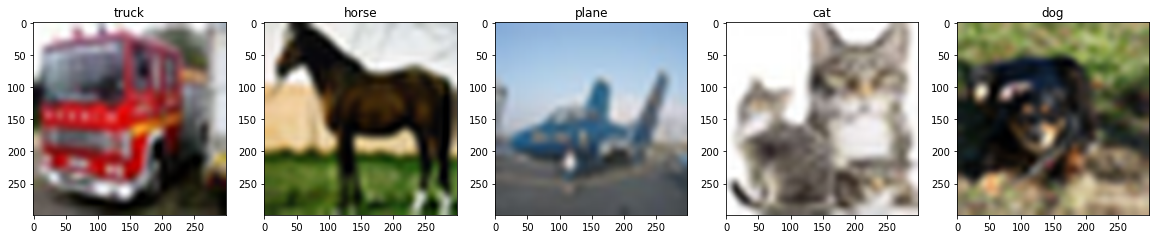

In [6]:
DataLoader = cifar10.CIFAR10()
train, test = DataLoader.get_dataloader(64, 4)
DataLoader.get_info()

**4.2 Transfer Learning**

Inception model has two output layer: one at the start, which function as an auxiliory logits output layer of 1000 neurons and the second one, in the end, also with 1000 neurons.

We can ignore the auxiliary classification layer and try to fit on the main one. <br>
Inception final module is: 
```
(fc): Linear(in_features=2048, out_features=1000, bias=True)
```
We need to delete this and end with a module of 10 outputs. One solution could be this one:<br>

```
(fc): Sequential((0): Linear(in_features=2048, out_features=512, bias=True)
                 (1): ReLU(inplace=True)
                 (2): Dropout(p=0.5, inplace=False)
                 (3): Linear(in_features=512, out_features=10, bias=True))
```

In [0]:
model.net.fc = nn.Sequential(
                                nn.Linear(in_features=2048, out_features=512, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=512, out_features=10, bias=True)
                                )
model.net = model.net.to(device)

EPOCH = 2
LR = 0.0002

### OPTIM, LOSS
optimizer = optim.Adam(model.net.parameters(), lr=LR)
loss_fn = loss_fn = nn.CrossEntropyLoss()

In [9]:
### TRAIN
train_loss, test_loss = [], []
accuracy_train, accuracy_test = [], []

for ep in range(EPOCH):
    print('Epoch {}'.format(ep+1))
    time.sleep(0.3)
    ### TRAINING
    loss, accuracy = model.train_step(train, loss_fn, optimizer)
    train_loss.append(loss)
    accuracy_train.append(accuracy)

    ### EVALUATION
    loss, accuracy = model.eval_step(test, loss_fn)
    test_loss.append(loss)
    accuracy_test.append(accuracy)

    ### DISPLAY
    print('Training Loss: {}'.format(np.round(train_loss[-1], 4)), end = '\t')
    print('Training Accuracy Score: {}'.format(np.round(accuracy_train[-1], 4)))
    print('Test Loss:     {}'.format(np.round(test_loss[-1], 4)), end='\t')
    print('Test Accuracy Score:     {}\n'.format(np.round(accuracy_test[-1], 4)))
    time.sleep(0.3)

Epoch 1


100%|██████████| 157/157 [00:44<00:00,  3.55it/s]


Training Loss: 0.3652	Training Accuracy Score: 0.8839
Test Loss:     0.1741	Test Accuracy Score:     0.9439

Epoch 2


100%|██████████| 157/157 [00:44<00:00,  3.55it/s]


Training Loss: 0.1607	Training Accuracy Score: 0.9479
Test Loss:     0.1753	Test Accuracy Score:     0.9447

Epoch 3


 20%|██        | 157/782 [02:26<09:41,  1.07it/s]

KeyboardInterrupt: ignored

**5. MNIST**

Here we try to do the same using the *MNIST* digit dataset. A collecation of hand-written digits which make this a 10 categories classifcation task

**5.1 Dataset**

We call the *mnist* object that return the *trainset* and the *testset* of the desired batch size.

The *mnist* get the data in the following way:
```
self.train_dataset = datasets.MNIST(root='../data/mnist', train=True, download=True, transform=self.transform)
self.test_dataset = datasets.MNIST(root='../data/mnist', train=False, download=True, transform=self.transform)
```

The *mnist* object use the following steps in the *transform.compose*:
```
transforms.Compose([transforms.Resize(self.dim, PIL.Image.LANCZOS),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)),
                                       RGB()])
```
where *RGB()* is a custom class that take one channel tensor image and expand it to a three channel tensor image.


Batch is a <class 'list'>
The 1st element is a <class 'torch.Tensor'> with shape torch.Size([128, 3, 299, 299])
The 2nd element is a <class 'torch.Tensor'> with shape torch.Size([128])


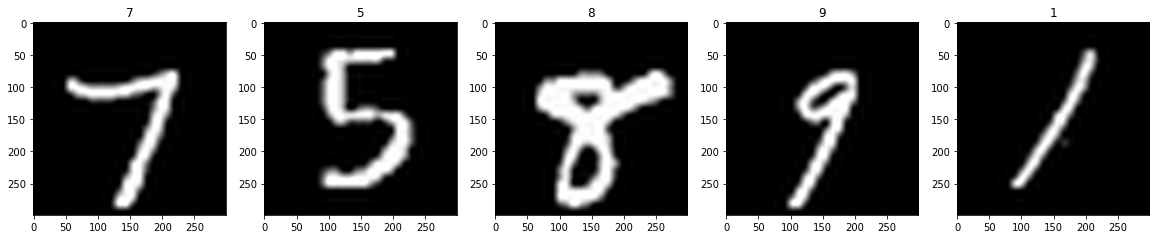

In [6]:
DataLoader = mnist.MNIST()
train, test = DataLoader.get_dataloader(128, 4)
DataLoader.get_info()

**5.2 Trasfer Learning**

In [0]:
model.net.fc = nn.Sequential(
                                nn.Linear(in_features=2048, out_features=512, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=512, out_features=10, bias=True)
                                )
model.net = model.net.to(device)

EPOCH = 2
LR = 0.0002

### OPTIM, LOSS
optimizer = optim.Adam(model.net.parameters(), lr=LR)
loss_fn = loss_fn = nn.CrossEntropyLoss()

In [9]:
### TRAIN
train_loss, test_loss = [], []
accuracy_train, accuracy_test = [], []

for ep in range(EPOCH):
    print('Epoch {}'.format(ep+1))
    time.sleep(0.3)
    ### TRAINING
    loss, accuracy = model.train_step(train, loss_fn, optimizer)
    train_loss.append(loss)
    accuracy_train.append(accuracy)

    ### EVALUATION
    loss, accuracy = model.eval_step(test, loss_fn)
    test_loss.append(loss)
    accuracy_test.append(accuracy)

    ### DISPLAY
    print('Training Loss: {}'.format(np.round(train_loss[-1], 4)), end = '\t')
    print('Training Accuracy Score: {}'.format(np.round(accuracy_train[-1], 4)))
    print('Test Loss:     {}'.format(np.round(test_loss[-1], 4)), end='\t')
    print('Test Accuracy Score:     {}\n'.format(np.round(accuracy_test[-1], 4)))
    time.sleep(0.3)

Epoch 1


100%|██████████| 79/79 [00:41<00:00,  1.88it/s]


Training Loss: 0.1134	Training Accuracy Score: 0.9707
Test Loss:     0.0234	Test Accuracy Score:     0.9932

Epoch 2


100%|██████████| 79/79 [00:42<00:00,  1.86it/s]


Training Loss: 0.0272	Training Accuracy Score: 0.9924
Test Loss:     0.0226	Test Accuracy Score:     0.9929



**5.3 Save results**

We can save the model using ```torch.save(model.net, PATH)``` and load it using ```model.net = torch.load(PATH)```

In [0]:
PATH = '../models/mnist_net.pth'
torch.save(model.net, PATH)